# 53. グレイコードによる空間充填曲線

## 目的
- 128ビットのビット列をFirestore/RDBMSで効率的に検索するための手法を検証
- グレイコードによるビット空間の1次元線形化
- B-Tree（範囲検索）での近傍探索の可能性を検証

## 理論的背景

### 通常の2進数の問題
```
7 = 0111
8 = 1000
数値差: 1, ハミング距離: 4（全ビット反転）
```

### グレイコードの特性
```
隣接するグレイコード値のハミング距離は常に1
→ グレイコード順でソートすれば、数値的に近い = ハミング距離が近い可能性が高い
```

### 変換式
```
binary_to_gray(n) = n XOR (n >> 1)
gray_to_binary(g) = 繰り返しXOR
```

## Firestoreでの実装
```javascript
// グレイコード値をインデックス化
db.collection('documents')
  .where('gray_code', '>=', query_gray - range)
  .where('gray_code', '<=', query_gray + range)
  .orderBy('gray_code')
```

## 評価指標
- グレイコード近傍とハミング距離近傍の相関
- 範囲検索での候補削減率とRecall
- 128ビット空間での実用性

## 0. セットアップ

In [1]:
import numpy as np
import time
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src')
from itq_lsh import ITQLSH, hamming_distance_batch

DATA_DIR = Path("../data")
np.random.seed(42)

In [2]:
# データロード
print("Loading data...")
start_time = time.time()

embeddings = np.load(DATA_DIR / "wikipedia_400k_e5_base_embeddings.npy")
hashes_128 = np.load(DATA_DIR / "wikipedia_400k_e5_base_hashes_128bits.npy")

print(f"Embeddings: {embeddings.shape}")
print(f"Hashes 128 bits: {hashes_128.shape}")
print(f"Load time: {time.time() - start_time:.1f}s")

Loading data...


Embeddings: (399029, 768)
Hashes 128 bits: (399029, 128)
Load time: 0.6s


## 1. グレイコード変換関数

In [3]:
def binary_to_gray(n: int) -> int:
    """2進数をグレイコードに変換"""
    return n ^ (n >> 1)

def gray_to_binary(g: int) -> int:
    """グレイコードを2進数に変換"""
    n = g
    mask = g >> 1
    while mask:
        n ^= mask
        mask >>= 1
    return n

def hash_to_int(hash_bits: np.ndarray) -> int:
    """バイナリハッシュを整数に変換（128ビット対応）"""
    result = 0
    for bit in hash_bits:
        result = (result << 1) | int(bit)
    return result

def hash_to_gray(hash_bits: np.ndarray) -> int:
    """バイナリハッシュをグレイコードに変換"""
    binary_val = hash_to_int(hash_bits)
    return binary_to_gray(binary_val)

# テスト
print("Gray code conversion test:")
for i in range(16):
    g = binary_to_gray(i)
    b = gray_to_binary(g)
    print(f"  {i:4d} -> gray: {g:4d} -> binary: {b:4d} | bin: {i:04b} -> {g:04b}")

Gray code conversion test:
     0 -> gray:    0 -> binary:    0 | bin: 0000 -> 0000
     1 -> gray:    1 -> binary:    1 | bin: 0001 -> 0001
     2 -> gray:    3 -> binary:    2 | bin: 0010 -> 0011
     3 -> gray:    2 -> binary:    3 | bin: 0011 -> 0010
     4 -> gray:    6 -> binary:    4 | bin: 0100 -> 0110
     5 -> gray:    7 -> binary:    5 | bin: 0101 -> 0111
     6 -> gray:    5 -> binary:    6 | bin: 0110 -> 0101
     7 -> gray:    4 -> binary:    7 | bin: 0111 -> 0100
     8 -> gray:   12 -> binary:    8 | bin: 1000 -> 1100
     9 -> gray:   13 -> binary:    9 | bin: 1001 -> 1101
    10 -> gray:   15 -> binary:   10 | bin: 1010 -> 1111
    11 -> gray:   14 -> binary:   11 | bin: 1011 -> 1110
    12 -> gray:   10 -> binary:   12 | bin: 1100 -> 1010
    13 -> gray:   11 -> binary:   13 | bin: 1101 -> 1011
    14 -> gray:    9 -> binary:   14 | bin: 1110 -> 1001
    15 -> gray:    8 -> binary:   15 | bin: 1111 -> 1000


In [4]:
# 隣接グレイコード間のハミング距離を確認
print("\nHamming distance between adjacent Gray codes:")
for i in range(15):
    g1 = binary_to_gray(i)
    g2 = binary_to_gray(i + 1)
    hamming = bin(g1 ^ g2).count('1')
    print(f"  gray({i})={g1:04b}, gray({i+1})={g2:04b}, hamming={hamming}")


Hamming distance between adjacent Gray codes:
  gray(0)=0000, gray(1)=0001, hamming=1
  gray(1)=0001, gray(2)=0011, hamming=1
  gray(2)=0011, gray(3)=0010, hamming=1
  gray(3)=0010, gray(4)=0110, hamming=1
  gray(4)=0110, gray(5)=0111, hamming=1
  gray(5)=0111, gray(6)=0101, hamming=1
  gray(6)=0101, gray(7)=0100, hamming=1
  gray(7)=0100, gray(8)=1100, hamming=1
  gray(8)=1100, gray(9)=1101, hamming=1
  gray(9)=1101, gray(10)=1111, hamming=1
  gray(10)=1111, gray(11)=1110, hamming=1
  gray(11)=1110, gray(12)=1010, hamming=1
  gray(12)=1010, gray(13)=1011, hamming=1
  gray(13)=1011, gray(14)=1001, hamming=1
  gray(14)=1001, gray(15)=1000, hamming=1


## 2. 128ビットハッシュのグレイコード変換

128ビットは大きすぎて単一の整数として扱えないため、セグメント分割して処理します。

In [5]:
def hash_to_segments(hash_bits: np.ndarray, segment_size: int = 64) -> tuple:
    """
    128ビットハッシュを複数のセグメントに分割して整数に変換
    
    Returns:
        tuple of integers (high, low) for 128-bit hash
    """
    n_bits = len(hash_bits)
    n_segments = (n_bits + segment_size - 1) // segment_size
    
    segments = []
    for i in range(n_segments):
        start = i * segment_size
        end = min(start + segment_size, n_bits)
        segment_bits = hash_bits[start:end]
        
        # パディング（最後のセグメントが短い場合）
        if len(segment_bits) < segment_size:
            segment_bits = np.concatenate([segment_bits, np.zeros(segment_size - len(segment_bits), dtype=np.uint8)])
        
        val = 0
        for bit in segment_bits:
            val = (val << 1) | int(bit)
        segments.append(val)
    
    return tuple(segments)

def segments_to_gray(segments: tuple) -> tuple:
    """各セグメントをグレイコードに変換"""
    return tuple(binary_to_gray(s) for s in segments)

# テスト
test_hash = hashes_128[0]
segments = hash_to_segments(test_hash, segment_size=64)
gray_segments = segments_to_gray(segments)

print(f"Test hash shape: {test_hash.shape}")
print(f"Binary segments (high, low): ({segments[0]:016x}, {segments[1]:016x})")
print(f"Gray segments (high, low): ({gray_segments[0]:016x}, {gray_segments[1]:016x})")

Test hash shape: (128,)
Binary segments (high, low): (e64aa7523b928ee8, 8f3f4114962f658e)
Gray segments (high, low): (956ff4fb265bc99c, c8a0e19edd38d749)


In [6]:
# 全ハッシュをグレイコードセグメントに変換
print("Converting all hashes to Gray code segments...")
start_time = time.time()

gray_high = np.zeros(len(hashes_128), dtype=np.uint64)
gray_low = np.zeros(len(hashes_128), dtype=np.uint64)

for i, h in enumerate(tqdm(hashes_128, desc="Converting")):
    segments = hash_to_segments(h, segment_size=64)
    gray_segs = segments_to_gray(segments)
    gray_high[i] = gray_segs[0]
    gray_low[i] = gray_segs[1]

print(f"Conversion time: {time.time() - start_time:.1f}s")
print(f"Gray high shape: {gray_high.shape}")
print(f"Gray low shape: {gray_low.shape}")

Converting all hashes to Gray code segments...


Converting:   0%|          | 0/399029 [00:00<?, ?it/s]

Converting:   1%|▏         | 5600/399029 [00:00<00:07, 55995.25it/s]

Converting:   3%|▎         | 11661/399029 [00:00<00:06, 58706.95it/s]

Converting:   4%|▍         | 17830/399029 [00:00<00:06, 60068.25it/s]

Converting:   6%|▌         | 24058/399029 [00:00<00:06, 60940.73it/s]

Converting:   8%|▊         | 30277/399029 [00:00<00:06, 61390.65it/s]

Converting:   9%|▉         | 36512/399029 [00:00<00:05, 61713.79it/s]

Converting:  11%|█         | 42728/399029 [00:00<00:05, 61857.22it/s]

Converting:  12%|█▏        | 48914/399029 [00:00<00:05, 61349.43it/s]

Converting:  14%|█▍        | 55171/399029 [00:00<00:05, 61725.73it/s]

Converting:  15%|█▌        | 61366/399029 [00:01<00:05, 61792.35it/s]

Converting:  17%|█▋        | 67572/399029 [00:01<00:05, 61873.56it/s]

Converting:  18%|█▊        | 73760/399029 [00:01<00:05, 61621.77it/s]

Converting:  20%|██        | 79923/399029 [00:01<00:05, 61530.94it/s]

Converting:  22%|██▏       | 86077/399029 [00:01<00:05, 61533.15it/s]

Converting:  23%|██▎       | 92239/399029 [00:01<00:04, 61558.44it/s]

Converting:  25%|██▍       | 98409/399029 [00:01<00:04, 61597.76it/s]

Converting:  26%|██▌       | 104569/399029 [00:01<00:04, 61584.39it/s]

Converting:  28%|██▊       | 110745/399029 [00:01<00:04, 61635.79it/s]

Converting:  29%|██▉       | 116917/399029 [00:01<00:04, 61658.03it/s]

Converting:  31%|███       | 123083/399029 [00:02<00:04, 61581.33it/s]

Converting:  32%|███▏      | 129254/399029 [00:02<00:04, 61618.02it/s]

Converting:  34%|███▍      | 135416/399029 [00:02<00:04, 61540.06it/s]

Converting:  35%|███▌      | 141571/399029 [00:02<00:04, 61537.52it/s]

Converting:  37%|███▋      | 147763/399029 [00:02<00:04, 61651.47it/s]

Converting:  39%|███▊      | 153933/399029 [00:02<00:03, 61663.04it/s]

Converting:  40%|████      | 160100/399029 [00:02<00:03, 61475.15it/s]

Converting:  42%|████▏     | 166248/399029 [00:02<00:03, 61362.71it/s]

Converting:  43%|████▎     | 172385/399029 [00:02<00:03, 61255.92it/s]

Converting:  45%|████▍     | 178511/399029 [00:02<00:03, 60653.50it/s]

Converting:  46%|████▋     | 184608/399029 [00:03<00:03, 60745.05it/s]

Converting:  48%|████▊     | 190704/399029 [00:03<00:03, 60806.97it/s]

Converting:  49%|████▉     | 196820/399029 [00:03<00:03, 60910.97it/s]

Converting:  51%|█████     | 202925/399029 [00:03<00:03, 60951.04it/s]

Converting:  52%|█████▏    | 209044/399029 [00:03<00:03, 61021.32it/s]

Converting:  54%|█████▍    | 215152/399029 [00:03<00:03, 61035.95it/s]

Converting:  55%|█████▌    | 221256/399029 [00:03<00:02, 60948.40it/s]

Converting:  57%|█████▋    | 227394/399029 [00:03<00:02, 61075.87it/s]

Converting:  59%|█████▊    | 233502/399029 [00:03<00:02, 60915.43it/s]

Converting:  60%|██████    | 239594/399029 [00:03<00:02, 60808.86it/s]

Converting:  62%|██████▏   | 245676/399029 [00:04<00:02, 60808.96it/s]

Converting:  63%|██████▎   | 251757/399029 [00:04<00:02, 60709.12it/s]

Converting:  65%|██████▍   | 257922/399029 [00:04<00:02, 60987.19it/s]

Converting:  66%|██████▌   | 264089/399029 [00:04<00:02, 61189.16it/s]

Converting:  68%|██████▊   | 270266/399029 [00:04<00:02, 61359.99it/s]

Converting:  69%|██████▉   | 276429/399029 [00:04<00:01, 61437.72it/s]

Converting:  71%|███████   | 282619/399029 [00:04<00:01, 61573.63it/s]

Converting:  72%|███████▏  | 288777/399029 [00:04<00:01, 61534.08it/s]

Converting:  74%|███████▍  | 294941/399029 [00:04<00:01, 61562.59it/s]

Converting:  75%|███████▌  | 301110/399029 [00:04<00:01, 61599.71it/s]

Converting:  77%|███████▋  | 307270/399029 [00:05<00:01, 61342.07it/s]

Converting:  79%|███████▊  | 313405/399029 [00:05<00:01, 61322.87it/s]

Converting:  80%|████████  | 319538/399029 [00:05<00:01, 61216.18it/s]

Converting:  82%|████████▏ | 325660/399029 [00:05<00:01, 61194.39it/s]

Converting:  83%|████████▎ | 331780/399029 [00:05<00:01, 61076.71it/s]

Converting:  85%|████████▍ | 337888/399029 [00:05<00:01, 60986.04it/s]

Converting:  86%|████████▌ | 343987/399029 [00:05<00:00, 60802.17it/s]

Converting:  88%|████████▊ | 350097/399029 [00:05<00:00, 60889.68it/s]

Converting:  89%|████████▉ | 356221/399029 [00:05<00:00, 60991.69it/s]

Converting:  91%|█████████ | 362375/399029 [00:05<00:00, 61154.27it/s]

Converting:  92%|█████████▏| 368491/399029 [00:06<00:00, 61088.16it/s]

Converting:  94%|█████████▍| 374600/399029 [00:06<00:00, 61070.59it/s]

Converting:  95%|█████████▌| 380708/399029 [00:06<00:00, 60981.93it/s]

Converting:  97%|█████████▋| 386839/399029 [00:06<00:00, 61077.50it/s]

Converting:  98%|█████████▊| 392947/399029 [00:06<00:00, 60998.07it/s]

Converting: 100%|██████████| 399029/399029 [00:06<00:00, 61215.33it/s]

Conversion time: 6.5s
Gray high shape: (399029,)
Gray low shape: (399029,)


## 3. グレイコード近傍とハミング距離の相関分析

In [7]:
def hamming_distance(h1: np.ndarray, h2: np.ndarray) -> int:
    """2つのハッシュ間のハミング距離"""
    return np.sum(h1 != h2)

def gray_distance(g1_high, g1_low, g2_high, g2_low) -> int:
    """
    グレイコード空間での「距離」
    ここでは単純に high セグメントの差 + low セグメントの差を使用
    """
    # 符号なし整数の差の絶対値
    high_diff = abs(int(g1_high) - int(g2_high))
    low_diff = abs(int(g1_low) - int(g2_low))
    return high_diff + low_diff

In [8]:
# グレイコード順でソートした場合の近傍のハミング距離を分析
n_samples = 1000
n_neighbors = 100

# グレイコードでソート（high優先、同値ならlow）
sort_indices = np.lexsort((gray_low, gray_high))

print(f"Analyzing {n_samples} samples...")

# ランダムなクエリをサンプリング
query_indices = np.random.choice(len(hashes_128), n_samples, replace=False)

gray_neighbor_hamming_dists = []  # グレイコード近傍のハミング距離
random_neighbor_hamming_dists = []  # ランダム近傍のハミング距離（比較用）

for q_idx in tqdm(query_indices, desc="Analyzing"):
    query_hash = hashes_128[q_idx]
    query_gray_high = gray_high[q_idx]
    query_gray_low = gray_low[q_idx]
    
    # グレイコードソート順でのクエリの位置を見つける
    sorted_pos = np.where(sort_indices == q_idx)[0][0]
    
    # 近傍のインデックス（ソート順で前後）
    start_pos = max(0, sorted_pos - n_neighbors // 2)
    end_pos = min(len(sort_indices), sorted_pos + n_neighbors // 2)
    neighbor_indices = sort_indices[start_pos:end_pos]
    neighbor_indices = neighbor_indices[neighbor_indices != q_idx]
    
    # グレイコード近傍のハミング距離
    for n_idx in neighbor_indices:
        h_dist = hamming_distance(query_hash, hashes_128[n_idx])
        gray_neighbor_hamming_dists.append(h_dist)
    
    # ランダム近傍のハミング距離（比較用）
    random_indices = np.random.choice(len(hashes_128), len(neighbor_indices), replace=False)
    for r_idx in random_indices:
        if r_idx != q_idx:
            h_dist = hamming_distance(query_hash, hashes_128[r_idx])
            random_neighbor_hamming_dists.append(h_dist)

gray_neighbor_hamming_dists = np.array(gray_neighbor_hamming_dists)
random_neighbor_hamming_dists = np.array(random_neighbor_hamming_dists)

Analyzing 1000 samples...


Analyzing:   0%|          | 0/1000 [00:00<?, ?it/s]

Analyzing:   2%|▏         | 19/1000 [00:00<00:05, 183.71it/s]

Analyzing:   4%|▍         | 38/1000 [00:00<00:05, 179.37it/s]

Analyzing:   6%|▌         | 58/1000 [00:00<00:05, 184.84it/s]

Analyzing:   8%|▊         | 77/1000 [00:00<00:05, 182.74it/s]

Analyzing:  10%|▉         | 96/1000 [00:00<00:05, 179.32it/s]

Analyzing:  11%|█▏        | 114/1000 [00:00<00:05, 174.84it/s]

Analyzing:  13%|█▎        | 132/1000 [00:00<00:04, 175.96it/s]

Analyzing:  15%|█▌        | 151/1000 [00:00<00:04, 177.51it/s]

Analyzing:  17%|█▋        | 169/1000 [00:00<00:04, 177.53it/s]

Analyzing:  19%|█▊        | 187/1000 [00:01<00:04, 177.60it/s]

Analyzing:  21%|██        | 206/1000 [00:01<00:04, 179.82it/s]

Analyzing:  22%|██▎       | 225/1000 [00:01<00:04, 182.80it/s]

Analyzing:  24%|██▍       | 244/1000 [00:01<00:04, 184.46it/s]

Analyzing:  26%|██▋       | 263/1000 [00:01<00:03, 185.43it/s]

Analyzing:  28%|██▊       | 282/1000 [00:01<00:03, 185.74it/s]

Analyzing:  30%|███       | 301/1000 [00:01<00:03, 186.46it/s]

Analyzing:  32%|███▏      | 320/1000 [00:01<00:03, 186.94it/s]

Analyzing:  34%|███▍      | 339/1000 [00:01<00:03, 187.45it/s]

Analyzing:  36%|███▌      | 358/1000 [00:01<00:03, 187.00it/s]

Analyzing:  38%|███▊      | 377/1000 [00:02<00:03, 186.28it/s]

Analyzing:  40%|███▉      | 396/1000 [00:02<00:03, 186.84it/s]

Analyzing:  42%|████▏     | 415/1000 [00:02<00:03, 186.35it/s]

Analyzing:  43%|████▎     | 434/1000 [00:02<00:03, 184.07it/s]

Analyzing:  45%|████▌     | 453/1000 [00:02<00:02, 183.49it/s]

Analyzing:  47%|████▋     | 472/1000 [00:02<00:02, 176.58it/s]

Analyzing:  49%|████▉     | 491/1000 [00:02<00:02, 179.69it/s]

Analyzing:  51%|█████     | 510/1000 [00:02<00:02, 181.43it/s]

Analyzing:  53%|█████▎    | 529/1000 [00:02<00:02, 183.04it/s]

Analyzing:  55%|█████▍    | 548/1000 [00:03<00:02, 184.10it/s]

Analyzing:  57%|█████▋    | 567/1000 [00:03<00:02, 185.29it/s]

Analyzing:  59%|█████▊    | 586/1000 [00:03<00:02, 186.34it/s]

Analyzing:  60%|██████    | 605/1000 [00:03<00:02, 186.99it/s]

Analyzing:  62%|██████▏   | 624/1000 [00:03<00:02, 187.45it/s]

Analyzing:  64%|██████▍   | 643/1000 [00:03<00:01, 187.49it/s]

Analyzing:  66%|██████▌   | 662/1000 [00:03<00:01, 187.68it/s]

Analyzing:  68%|██████▊   | 681/1000 [00:03<00:01, 188.07it/s]

Analyzing:  70%|███████   | 700/1000 [00:03<00:01, 188.22it/s]

Analyzing:  72%|███████▏  | 719/1000 [00:03<00:01, 188.62it/s]

Analyzing:  74%|███████▍  | 738/1000 [00:04<00:01, 188.18it/s]

Analyzing:  76%|███████▌  | 757/1000 [00:04<00:01, 188.43it/s]

Analyzing:  78%|███████▊  | 776/1000 [00:04<00:01, 188.67it/s]

Analyzing:  80%|███████▉  | 795/1000 [00:04<00:01, 188.51it/s]

Analyzing:  81%|████████▏ | 814/1000 [00:04<00:00, 186.10it/s]

Analyzing:  83%|████████▎ | 833/1000 [00:04<00:00, 186.88it/s]

Analyzing:  85%|████████▌ | 852/1000 [00:04<00:00, 185.91it/s]

Analyzing:  87%|████████▋ | 871/1000 [00:04<00:00, 186.78it/s]

Analyzing:  89%|████████▉ | 890/1000 [00:04<00:00, 187.19it/s]

Analyzing:  91%|█████████ | 909/1000 [00:04<00:00, 187.52it/s]

Analyzing:  93%|█████████▎| 928/1000 [00:05<00:00, 187.77it/s]

Analyzing:  95%|█████████▍| 947/1000 [00:05<00:00, 188.26it/s]

Analyzing:  97%|█████████▋| 967/1000 [00:05<00:00, 189.41it/s]

Analyzing:  99%|█████████▊| 987/1000 [00:05<00:00, 189.63it/s]

Analyzing: 100%|██████████| 1000/1000 [00:05<00:00, 185.10it/s]

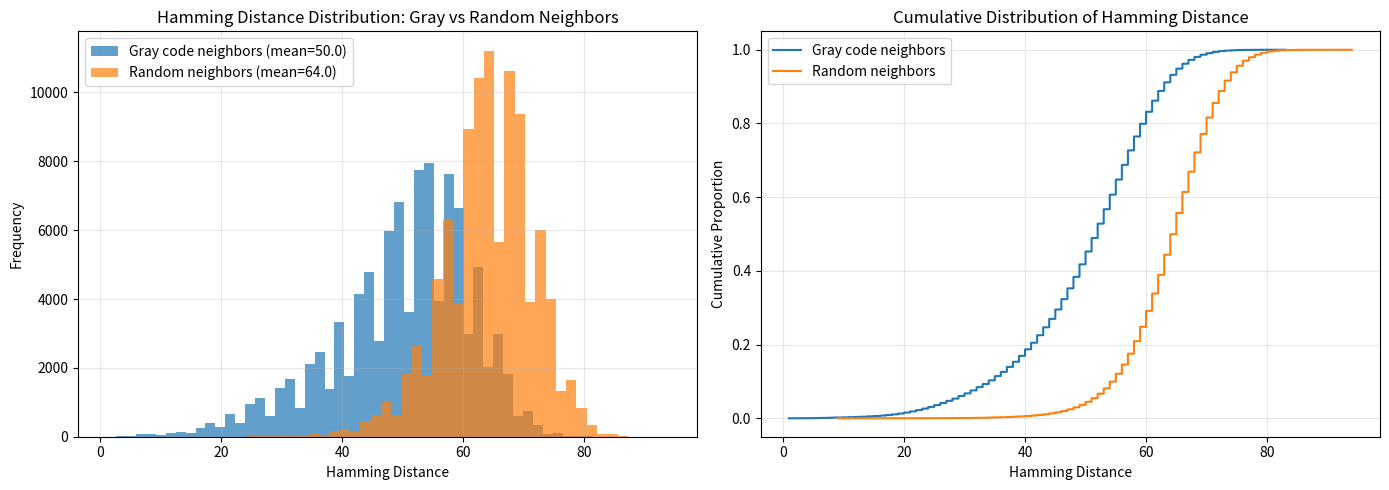

In [9]:
# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ヒストグラム比較
ax1 = axes[0]
ax1.hist(gray_neighbor_hamming_dists, bins=50, alpha=0.7, label=f'Gray code neighbors (mean={gray_neighbor_hamming_dists.mean():.1f})')
ax1.hist(random_neighbor_hamming_dists, bins=50, alpha=0.7, label=f'Random neighbors (mean={random_neighbor_hamming_dists.mean():.1f})')
ax1.set_xlabel('Hamming Distance')
ax1.set_ylabel('Frequency')
ax1.set_title('Hamming Distance Distribution: Gray vs Random Neighbors')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 累積分布
ax2 = axes[1]
sorted_gray = np.sort(gray_neighbor_hamming_dists)
sorted_random = np.sort(random_neighbor_hamming_dists)
ax2.plot(sorted_gray, np.arange(1, len(sorted_gray)+1) / len(sorted_gray), label='Gray code neighbors')
ax2.plot(sorted_random, np.arange(1, len(sorted_random)+1) / len(sorted_random), label='Random neighbors')
ax2.set_xlabel('Hamming Distance')
ax2.set_ylabel('Cumulative Proportion')
ax2.set_title('Cumulative Distribution of Hamming Distance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / '53_gray_vs_random_hamming.png', dpi=100, bbox_inches='tight')
plt.show()

In [10]:
# 統計サマリー
print("Hamming Distance Statistics:")
print(f"\nGray code neighbors ({n_neighbors} neighbors per query):")
print(f"  Mean: {gray_neighbor_hamming_dists.mean():.1f}")
print(f"  Std: {gray_neighbor_hamming_dists.std():.1f}")
print(f"  Median: {np.median(gray_neighbor_hamming_dists):.1f}")
print(f"  Min: {gray_neighbor_hamming_dists.min()}")
print(f"  Max: {gray_neighbor_hamming_dists.max()}")

print(f"\nRandom neighbors (same count):")
print(f"  Mean: {random_neighbor_hamming_dists.mean():.1f}")
print(f"  Std: {random_neighbor_hamming_dists.std():.1f}")
print(f"  Median: {np.median(random_neighbor_hamming_dists):.1f}")
print(f"  Min: {random_neighbor_hamming_dists.min()}")
print(f"  Max: {random_neighbor_hamming_dists.max()}")

print(f"\nImprovement: {random_neighbor_hamming_dists.mean() - gray_neighbor_hamming_dists.mean():.1f} bits closer")

Hamming Distance Statistics:

Gray code neighbors (100 neighbors per query):
  Mean: 50.0
  Std: 11.4
  Median: 52.0
  Min: 1
  Max: 83

Random neighbors (same count):
  Mean: 64.0
  Std: 7.4
  Median: 65.0
  Min: 9
  Max: 94

Improvement: 13.9 bits closer


## 4. グレイコード範囲検索の精度評価

In [11]:
def gray_range_filter(query_idx: int, gray_high: np.ndarray, gray_low: np.ndarray, 
                      sort_indices: np.ndarray, n_candidates: int) -> np.ndarray:
    """
    グレイコードソート順で近傍を取得（範囲検索をシミュレート）
    
    Args:
        query_idx: クエリのインデックス
        gray_high, gray_low: 全ドキュメントのグレイコード
        sort_indices: グレイコードでソートしたインデックス
        n_candidates: 取得する候補数
    
    Returns:
        candidate_indices: 候補のインデックス
    """
    # ソート順でのクエリの位置
    sorted_pos = np.where(sort_indices == query_idx)[0][0]
    
    # 前後から候補を取得
    half = n_candidates // 2
    start_pos = max(0, sorted_pos - half)
    end_pos = min(len(sort_indices), sorted_pos + half + 1)
    
    # 端の調整
    if start_pos == 0:
        end_pos = min(len(sort_indices), n_candidates + 1)
    if end_pos == len(sort_indices):
        start_pos = max(0, len(sort_indices) - n_candidates - 1)
    
    candidates = sort_indices[start_pos:end_pos]
    candidates = candidates[candidates != query_idx]  # 自分自身を除外
    
    return candidates

In [12]:
def evaluate_gray_filter(
    embeddings: np.ndarray,
    hashes: np.ndarray,
    gray_high: np.ndarray,
    gray_low: np.ndarray,
    sort_indices: np.ndarray,
    candidate_counts: list,
    n_queries: int = 100,
    top_k: int = 10,
    rerank_limits: list = [100, 500, 1000]
):
    """
    グレイコードフィルタリングを評価
    """
    n_docs = len(embeddings)
    query_indices = np.random.choice(n_docs, n_queries, replace=False)
    
    # Ground truth計算
    print(f"Computing ground truth for {n_queries} queries...")
    ground_truth = []
    for q_idx in tqdm(query_indices, desc="Ground truth"):
        sims = embeddings @ embeddings[q_idx]
        sims[q_idx] = -1
        top_indices = np.argsort(sims)[-top_k:][::-1]
        ground_truth.append(set(top_indices))
    
    results = []
    
    for n_cand in candidate_counts:
        print(f"\nEvaluating n_candidates={n_cand}...")
        
        filter_recall = []
        recalls = {limit: [] for limit in rerank_limits}
        
        for i, q_idx in enumerate(tqdm(query_indices, desc=f"n_cand={n_cand}")):
            # Step1: グレイコード範囲フィルタ
            candidates = gray_range_filter(q_idx, gray_high, gray_low, sort_indices, n_cand)
            
            # フィルタ後にTop-Kが含まれるか
            gt_in_candidates = len(ground_truth[i] & set(candidates)) / top_k
            filter_recall.append(gt_in_candidates)
            
            if len(candidates) == 0:
                for limit in rerank_limits:
                    recalls[limit].append(0.0)
                continue
            
            # Step2: ハミング距離でソート
            query_hash = hashes[q_idx]
            candidate_hashes = hashes[candidates]
            distances = hamming_distance_batch(query_hash, candidate_hashes)
            sorted_indices = np.argsort(distances)
            
            # 各リランク数でのRecall計算
            for limit in rerank_limits:
                actual_limit = min(limit, len(sorted_indices))
                top_candidates = set(candidates[sorted_indices[:actual_limit]])
                recall = len(top_candidates & ground_truth[i]) / top_k
                recalls[limit].append(recall)
        
        # 結果集計
        reduction_rate = 1 - n_cand / n_docs
        result = {
            'n_candidates': n_cand,
            'reduction_rate': reduction_rate,
            'filter_recall': np.mean(filter_recall),
        }
        
        for limit in rerank_limits:
            result[f'recall@{top_k}_limit{limit}'] = np.mean(recalls[limit])
        
        results.append(result)
        
        print(f"  Reduction: {reduction_rate:.1%}")
        print(f"  Filter Recall: {result['filter_recall']:.1%}")
        print(f"  Recall@10 (after rerank): {result['recall@10_limit1000']:.1%}")
    
    return results

In [13]:
# 評価実行
candidate_counts = [1000, 2000, 5000, 10000, 20000, 50000, 100000]

results_gray = evaluate_gray_filter(
    embeddings, hashes_128, gray_high, gray_low, sort_indices,
    candidate_counts=candidate_counts,
    n_queries=100,
    top_k=10
)

Computing ground truth for 100 queries...


Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   3%|▎         | 3/100 [00:00<00:04, 22.47it/s]

Ground truth:   6%|▌         | 6/100 [00:00<00:04, 22.53it/s]

Ground truth:   9%|▉         | 9/100 [00:00<00:04, 22.59it/s]

Ground truth:  12%|█▏        | 12/100 [00:00<00:03, 22.50it/s]

Ground truth:  15%|█▌        | 15/100 [00:00<00:03, 22.42it/s]

Ground truth:  18%|█▊        | 18/100 [00:00<00:03, 22.31it/s]

Ground truth:  21%|██        | 21/100 [00:00<00:03, 22.26it/s]

Ground truth:  24%|██▍       | 24/100 [00:01<00:03, 22.45it/s]

Ground truth:  27%|██▋       | 27/100 [00:01<00:03, 22.67it/s]

Ground truth:  30%|███       | 30/100 [00:01<00:03, 22.85it/s]

Ground truth:  33%|███▎      | 33/100 [00:01<00:02, 22.97it/s]

Ground truth:  36%|███▌      | 36/100 [00:01<00:02, 23.07it/s]

Ground truth:  39%|███▉      | 39/100 [00:01<00:02, 23.11it/s]

Ground truth:  42%|████▏     | 42/100 [00:01<00:02, 23.16it/s]

Ground truth:  45%|████▌     | 45/100 [00:01<00:02, 22.97it/s]

Ground truth:  48%|████▊     | 48/100 [00:02<00:02, 22.56it/s]

Ground truth:  51%|█████     | 51/100 [00:02<00:02, 22.55it/s]

Ground truth:  54%|█████▍    | 54/100 [00:02<00:02, 22.29it/s]

Ground truth:  57%|█████▋    | 57/100 [00:02<00:01, 22.53it/s]

Ground truth:  60%|██████    | 60/100 [00:02<00:01, 22.74it/s]

Ground truth:  63%|██████▎   | 63/100 [00:02<00:01, 22.88it/s]

Ground truth:  66%|██████▌   | 66/100 [00:02<00:01, 22.74it/s]

Ground truth:  69%|██████▉   | 69/100 [00:03<00:01, 22.59it/s]

Ground truth:  72%|███████▏  | 72/100 [00:03<00:01, 22.30it/s]

Ground truth:  75%|███████▌  | 75/100 [00:03<00:01, 22.39it/s]

Ground truth:  78%|███████▊  | 78/100 [00:03<00:00, 22.58it/s]

Ground truth:  81%|████████  | 81/100 [00:03<00:00, 22.77it/s]

Ground truth:  84%|████████▍ | 84/100 [00:03<00:00, 22.90it/s]

Ground truth:  87%|████████▋ | 87/100 [00:03<00:00, 23.03it/s]

Ground truth:  90%|█████████ | 90/100 [00:03<00:00, 23.10it/s]

Ground truth:  93%|█████████▎| 93/100 [00:04<00:00, 23.16it/s]

Ground truth:  96%|█████████▌| 96/100 [00:04<00:00, 23.12it/s]

Ground truth:  99%|█████████▉| 99/100 [00:04<00:00, 23.15it/s]

Ground truth: 100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


Evaluating n_candidates=1000...


n_cand=1000:   0%|          | 0/100 [00:00<?, ?it/s]

n_cand=1000: 100%|██████████| 100/100 [00:00<00:00, 1516.61it/s]

  Reduction: 99.7%
  Filter Recall: 11.3%
  Recall@10 (after rerank): 11.3%

Evaluating n_candidates=2000...


n_cand=2000:   0%|          | 0/100 [00:00<?, ?it/s]

n_cand=2000: 100%|██████████| 100/100 [00:00<00:00, 1480.55it/s]

  Reduction: 99.5%
  Filter Recall: 15.4%
  Recall@10 (after rerank): 15.4%

Evaluating n_candidates=5000...


n_cand=5000:   0%|          | 0/100 [00:00<?, ?it/s]

n_cand=5000:  75%|███████▌  | 75/100 [00:00<00:00, 740.92it/s]

n_cand=5000: 100%|██████████| 100/100 [00:00<00:00, 737.02it/s]

  Reduction: 98.7%
  Filter Recall: 21.4%
  Recall@10 (after rerank): 21.4%

Evaluating n_candidates=10000...


n_cand=10000:   0%|          | 0/100 [00:00<?, ?it/s]

n_cand=10000:  43%|████▎     | 43/100 [00:00<00:00, 424.22it/s]

n_cand=10000:  86%|████████▌ | 86/100 [00:00<00:00, 422.68it/s]

n_cand=10000: 100%|██████████| 100/100 [00:00<00:00, 421.63it/s]

  Reduction: 97.5%
  Filter Recall: 28.5%
  Recall@10 (after rerank): 28.5%

Evaluating n_candidates=20000...


n_cand=20000:   0%|          | 0/100 [00:00<?, ?it/s]

n_cand=20000:  21%|██        | 21/100 [00:00<00:00, 203.49it/s]

n_cand=20000:  42%|████▏     | 42/100 [00:00<00:00, 204.53it/s]

n_cand=20000:  63%|██████▎   | 63/100 [00:00<00:00, 204.47it/s]

n_cand=20000:  84%|████████▍ | 84/100 [00:00<00:00, 201.58it/s]

n_cand=20000: 100%|██████████| 100/100 [00:00<00:00, 201.33it/s]

  Reduction: 95.0%
  Filter Recall: 35.1%
  Recall@10 (after rerank): 34.7%

Evaluating n_candidates=50000...


n_cand=50000:   0%|          | 0/100 [00:00<?, ?it/s]

n_cand=50000:   7%|▋         | 7/100 [00:00<00:01, 69.51it/s]

n_cand=50000:  16%|█▌        | 16/100 [00:00<00:01, 76.77it/s]

n_cand=50000:  25%|██▌       | 25/100 [00:00<00:00, 78.32it/s]

n_cand=50000:  33%|███▎      | 33/100 [00:00<00:00, 78.34it/s]

n_cand=50000:  41%|████      | 41/100 [00:00<00:00, 77.98it/s]

n_cand=50000:  49%|████▉     | 49/100 [00:00<00:00, 78.61it/s]

n_cand=50000:  58%|█████▊    | 58/100 [00:00<00:00, 79.26it/s]

n_cand=50000:  67%|██████▋   | 67/100 [00:00<00:00, 79.51it/s]

n_cand=50000:  75%|███████▌  | 75/100 [00:00<00:00, 79.60it/s]

n_cand=50000:  83%|████████▎ | 83/100 [00:01<00:00, 79.56it/s]

n_cand=50000:  92%|█████████▏| 92/100 [00:01<00:00, 79.43it/s]

n_cand=50000: 100%|██████████| 100/100 [00:01<00:00, 77.68it/s]

n_cand=50000: 100%|██████████| 100/100 [00:01<00:00, 78.28it/s]

  Reduction: 87.5%
  Filter Recall: 45.5%
  Recall@10 (after rerank): 44.6%

Evaluating n_candidates=100000...


n_cand=100000:   0%|          | 0/100 [00:00<?, ?it/s]

n_cand=100000:   4%|▍         | 4/100 [00:00<00:03, 31.64it/s]

n_cand=100000:   8%|▊         | 8/100 [00:00<00:02, 34.61it/s]

n_cand=100000:  12%|█▏        | 12/100 [00:00<00:02, 34.63it/s]

n_cand=100000:  16%|█▌        | 16/100 [00:00<00:02, 34.90it/s]

n_cand=100000:  20%|██        | 20/100 [00:00<00:02, 34.89it/s]

n_cand=100000:  24%|██▍       | 24/100 [00:00<00:02, 35.77it/s]

n_cand=100000:  28%|██▊       | 28/100 [00:00<00:02, 35.74it/s]

n_cand=100000:  32%|███▏      | 32/100 [00:00<00:01, 35.99it/s]

n_cand=100000:  36%|███▌      | 36/100 [00:01<00:01, 35.70it/s]

n_cand=100000:  40%|████      | 40/100 [00:01<00:01, 35.47it/s]

n_cand=100000:  44%|████▍     | 44/100 [00:01<00:01, 36.11it/s]

n_cand=100000:  48%|████▊     | 48/100 [00:01<00:01, 36.58it/s]

n_cand=100000:  52%|█████▏    | 52/100 [00:01<00:01, 35.90it/s]

n_cand=100000:  56%|█████▌    | 56/100 [00:01<00:01, 35.67it/s]

n_cand=100000:  60%|██████    | 60/100 [00:01<00:01, 35.35it/s]

n_cand=100000:  64%|██████▍   | 64/100 [00:01<00:01, 35.10it/s]

n_cand=100000:  68%|██████▊   | 68/100 [00:01<00:00, 35.05it/s]

n_cand=100000:  72%|███████▏  | 72/100 [00:02<00:00, 34.57it/s]

n_cand=100000:  76%|███████▌  | 76/100 [00:02<00:00, 35.48it/s]

n_cand=100000:  80%|████████  | 80/100 [00:02<00:00, 35.87it/s]

n_cand=100000:  84%|████████▍ | 84/100 [00:02<00:00, 36.47it/s]

n_cand=100000:  88%|████████▊ | 88/100 [00:02<00:00, 35.84it/s]

n_cand=100000:  92%|█████████▏| 92/100 [00:02<00:00, 34.64it/s]

n_cand=100000:  96%|█████████▌| 96/100 [00:02<00:00, 34.18it/s]

n_cand=100000: 100%|██████████| 100/100 [00:02<00:00, 33.70it/s]

n_cand=100000: 100%|██████████| 100/100 [00:02<00:00, 35.14it/s]

  Reduction: 74.9%
  Filter Recall: 56.9%
  Recall@10 (after rerank): 54.5%


In [14]:
# 結果サマリー
import pandas as pd

df_results = pd.DataFrame(results_gray)
print("\nGray Code Filtering Results Summary:")
print(df_results.to_string(index=False))


Gray Code Filtering Results Summary:
 n_candidates  reduction_rate  filter_recall  recall@10_limit100  recall@10_limit500  recall@10_limit1000
         1000        0.997494          0.113               0.112               0.113                0.113
         2000        0.994988          0.154               0.145               0.154                0.154
         5000        0.987470          0.214               0.184               0.213                0.214
        10000        0.974939          0.285               0.231               0.281                0.285
        20000        0.949878          0.351               0.277               0.337                0.347
        50000        0.874696          0.455               0.335               0.426                0.446
       100000        0.749392          0.569               0.388               0.518                0.545


## 5. 結果の可視化

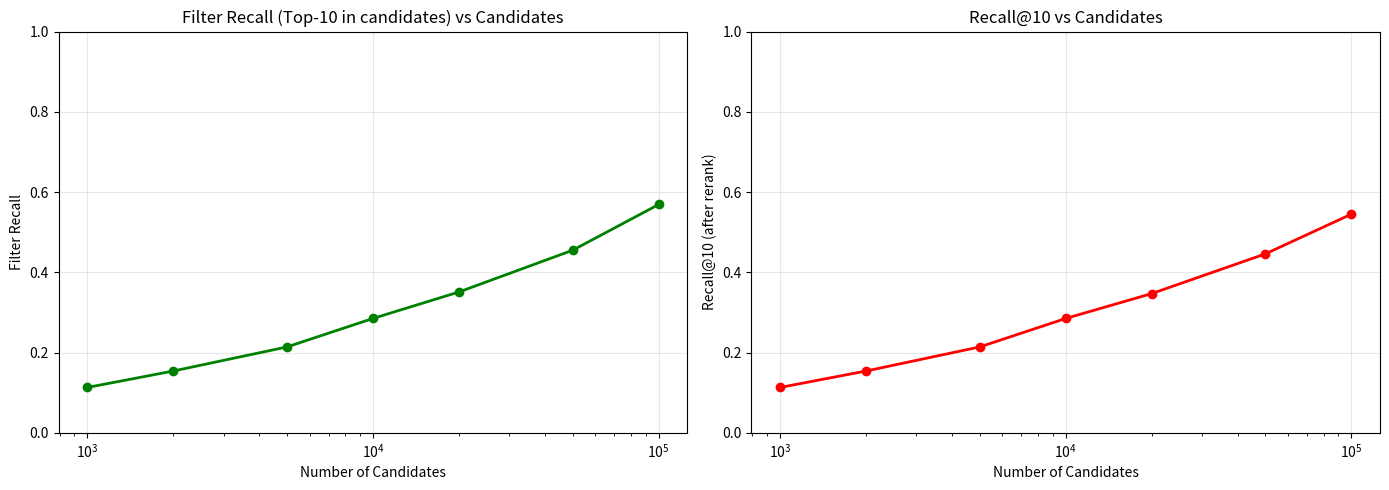

In [15]:
# 候補数 vs Recall
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter Recall
ax1 = axes[0]
ax1.plot([r['n_candidates'] for r in results_gray], 
         [r['filter_recall'] for r in results_gray], 'go-', linewidth=2)
ax1.set_xlabel('Number of Candidates')
ax1.set_ylabel('Filter Recall')
ax1.set_title('Filter Recall (Top-10 in candidates) vs Candidates')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Recall@10
ax2 = axes[1]
ax2.plot([r['n_candidates'] for r in results_gray], 
         [r['recall@10_limit1000'] for r in results_gray], 'ro-', linewidth=2)
ax2.set_xlabel('Number of Candidates')
ax2.set_ylabel('Recall@10 (after rerank)')
ax2.set_title('Recall@10 vs Candidates')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(DATA_DIR / '53_gray_code_recall.png', dpi=100, bbox_inches='tight')
plt.show()

## 6. ベースラインとの比較

In [16]:
# ベースライン（フィルタなし）
def evaluate_baseline(embeddings, hashes, n_queries=100, top_k=10, candidate_limits=[100, 500, 1000]):
    n_docs = len(embeddings)
    query_indices = np.random.choice(n_docs, n_queries, replace=False)
    
    ground_truth = []
    for q_idx in tqdm(query_indices, desc="Ground truth"):
        sims = embeddings @ embeddings[q_idx]
        sims[q_idx] = -1
        top_indices = np.argsort(sims)[-top_k:][::-1]
        ground_truth.append(set(top_indices))
    
    recalls = {limit: [] for limit in candidate_limits}
    
    for i, q_idx in enumerate(tqdm(query_indices, desc="Queries")):
        query_hash = hashes[q_idx]
        distances = hamming_distance_batch(query_hash, hashes)
        distances[q_idx] = 999
        sorted_indices = np.argsort(distances)
        
        for limit in candidate_limits:
            top_candidates = set(sorted_indices[:limit])
            recall = len(top_candidates & ground_truth[i]) / top_k
            recalls[limit].append(recall)
    
    return {f'recall@{top_k}_limit{limit}': np.mean(recalls[limit]) for limit in candidate_limits}

print("Baseline (full hamming distance):")
baseline = evaluate_baseline(embeddings, hashes_128)
for k, v in baseline.items():
    print(f"  {k}: {v:.1%}")

Baseline (full hamming distance):


Ground truth:   0%|          | 0/100 [00:00<?, ?it/s]

Ground truth:   3%|▎         | 3/100 [00:00<00:04, 22.58it/s]

Ground truth:   6%|▌         | 6/100 [00:00<00:04, 22.99it/s]

Ground truth:   9%|▉         | 9/100 [00:00<00:03, 23.05it/s]

Ground truth:  12%|█▏        | 12/100 [00:00<00:03, 23.07it/s]

Ground truth:  15%|█▌        | 15/100 [00:00<00:03, 22.76it/s]

Ground truth:  18%|█▊        | 18/100 [00:00<00:03, 22.37it/s]

Ground truth:  21%|██        | 21/100 [00:00<00:03, 22.49it/s]

Ground truth:  24%|██▍       | 24/100 [00:01<00:03, 22.68it/s]

Ground truth:  27%|██▋       | 27/100 [00:01<00:03, 22.87it/s]

Ground truth:  30%|███       | 30/100 [00:01<00:03, 22.57it/s]

Ground truth:  33%|███▎      | 33/100 [00:01<00:02, 22.43it/s]

Ground truth:  36%|███▌      | 36/100 [00:01<00:02, 22.46it/s]

Ground truth:  39%|███▉      | 39/100 [00:01<00:02, 22.25it/s]

Ground truth:  42%|████▏     | 42/100 [00:01<00:02, 22.54it/s]

Ground truth:  45%|████▌     | 45/100 [00:01<00:02, 22.75it/s]

Ground truth:  48%|████▊     | 48/100 [00:02<00:02, 22.88it/s]

Ground truth:  51%|█████     | 51/100 [00:02<00:02, 23.00it/s]

Ground truth:  54%|█████▍    | 54/100 [00:02<00:01, 23.10it/s]

Ground truth:  57%|█████▋    | 57/100 [00:02<00:01, 23.18it/s]

Ground truth:  60%|██████    | 60/100 [00:02<00:01, 23.24it/s]

Ground truth:  63%|██████▎   | 63/100 [00:02<00:01, 23.29it/s]

Ground truth:  66%|██████▌   | 66/100 [00:02<00:01, 23.30it/s]

Ground truth:  69%|██████▉   | 69/100 [00:03<00:01, 23.07it/s]

Ground truth:  72%|███████▏  | 72/100 [00:03<00:01, 22.69it/s]

Ground truth:  75%|███████▌  | 75/100 [00:03<00:01, 22.62it/s]

Ground truth:  78%|███████▊  | 78/100 [00:03<00:00, 22.38it/s]

Ground truth:  81%|████████  | 81/100 [00:03<00:00, 22.66it/s]

Ground truth:  84%|████████▍ | 84/100 [00:03<00:00, 22.82it/s]

Ground truth:  87%|████████▋ | 87/100 [00:03<00:00, 22.45it/s]

Ground truth:  90%|█████████ | 90/100 [00:03<00:00, 22.23it/s]

Ground truth:  93%|█████████▎| 93/100 [00:04<00:00, 22.16it/s]

Ground truth:  96%|█████████▌| 96/100 [00:04<00:00, 22.49it/s]

Ground truth:  99%|█████████▉| 99/100 [00:04<00:00, 22.73it/s]

Ground truth: 100%|██████████| 100/100 [00:04<00:00, 22.72it/s]

Queries:   0%|          | 0/100 [00:00<?, ?it/s]

Queries:   2%|▏         | 2/100 [00:00<00:05, 17.96it/s]

Queries:   4%|▍         | 4/100 [00:00<00:05, 18.95it/s]

Queries:   6%|▌         | 6/100 [00:00<00:04, 19.17it/s]

Queries:   8%|▊         | 8/100 [00:00<00:04, 19.36it/s]

Queries:  10%|█         | 10/100 [00:00<00:04, 19.34it/s]

Queries:  12%|█▏        | 12/100 [00:00<00:04, 19.39it/s]

Queries:  14%|█▍        | 14/100 [00:00<00:04, 19.43it/s]

Queries:  16%|█▌        | 16/100 [00:00<00:04, 19.48it/s]

Queries:  18%|█▊        | 18/100 [00:00<00:04, 19.53it/s]

Queries:  20%|██        | 20/100 [00:01<00:04, 19.50it/s]

Queries:  22%|██▏       | 22/100 [00:01<00:04, 19.43it/s]

Queries:  24%|██▍       | 24/100 [00:01<00:03, 19.51it/s]

Queries:  26%|██▌       | 26/100 [00:01<00:03, 19.56it/s]

Queries:  28%|██▊       | 28/100 [00:01<00:03, 19.44it/s]

Queries:  30%|███       | 30/100 [00:01<00:03, 19.51it/s]

Queries:  32%|███▏      | 32/100 [00:01<00:03, 19.54it/s]

Queries:  34%|███▍      | 34/100 [00:01<00:03, 19.44it/s]

Queries:  36%|███▌      | 36/100 [00:01<00:03, 19.43it/s]

Queries:  38%|███▊      | 38/100 [00:01<00:03, 19.55it/s]

Queries:  40%|████      | 40/100 [00:02<00:03, 19.62it/s]

Queries:  42%|████▏     | 42/100 [00:02<00:02, 19.62it/s]

Queries:  44%|████▍     | 44/100 [00:02<00:02, 19.60it/s]

Queries:  46%|████▌     | 46/100 [00:02<00:02, 19.52it/s]

Queries:  48%|████▊     | 48/100 [00:02<00:02, 19.56it/s]

Queries:  50%|█████     | 50/100 [00:02<00:02, 19.53it/s]

Queries:  52%|█████▏    | 52/100 [00:02<00:02, 19.47it/s]

Queries:  54%|█████▍    | 54/100 [00:02<00:02, 19.54it/s]

Queries:  56%|█████▌    | 56/100 [00:02<00:02, 19.60it/s]

Queries:  58%|█████▊    | 58/100 [00:02<00:02, 19.63it/s]

Queries:  60%|██████    | 60/100 [00:03<00:02, 19.60it/s]

Queries:  62%|██████▏   | 62/100 [00:03<00:01, 19.69it/s]

Queries:  64%|██████▍   | 64/100 [00:03<00:01, 19.66it/s]

Queries:  66%|██████▌   | 66/100 [00:03<00:01, 19.71it/s]

Queries:  68%|██████▊   | 68/100 [00:03<00:01, 19.79it/s]

Queries:  70%|███████   | 70/100 [00:03<00:01, 19.81it/s]

Queries:  72%|███████▏  | 72/100 [00:03<00:01, 19.74it/s]

Queries:  74%|███████▍  | 74/100 [00:03<00:01, 19.74it/s]

Queries:  76%|███████▌  | 76/100 [00:03<00:01, 19.64it/s]

Queries:  78%|███████▊  | 78/100 [00:03<00:01, 19.61it/s]

Queries:  80%|████████  | 80/100 [00:04<00:01, 19.70it/s]

Queries:  82%|████████▏ | 82/100 [00:04<00:00, 19.72it/s]

Queries:  84%|████████▍ | 84/100 [00:04<00:00, 19.70it/s]

Queries:  86%|████████▌ | 86/100 [00:04<00:00, 19.57it/s]

Queries:  88%|████████▊ | 88/100 [00:04<00:00, 19.54it/s]

Queries:  90%|█████████ | 90/100 [00:04<00:00, 19.60it/s]

Queries:  92%|█████████▏| 92/100 [00:04<00:00, 19.63it/s]

Queries:  94%|█████████▍| 94/100 [00:04<00:00, 19.71it/s]

Queries:  96%|█████████▌| 96/100 [00:04<00:00, 19.72it/s]

Queries:  98%|█████████▊| 98/100 [00:05<00:00, 19.76it/s]

Queries: 100%|██████████| 100/100 [00:05<00:00, 19.75it/s]

Queries: 100%|██████████| 100/100 [00:05<00:00, 19.57it/s]

  recall@10_limit100: 60.4%
  recall@10_limit500: 84.5%
  recall@10_limit1000: 90.5%


In [17]:
# 比較表
print("\n" + "="*80)
print("Comparison: Gray Code Filter vs Baseline (128 bits)")
print("="*80)

print(f"\n{'Method':<25} {'Candidates':>12} {'Reduction':>12} {'Filter Recall':>15} {'R@10 lim1000':>13}")
print("-"*80)

# ベースライン
print(f"{'Baseline (all)':<25} {len(embeddings):>12} {'0.0%':>12} {'100.0%':>15} {baseline['recall@10_limit1000']:>12.1%}")

# グレイコードフィルタ
for r in results_gray:
    method = f"Gray n={r['n_candidates']}"
    print(f"{method:<25} {r['n_candidates']:>12} {r['reduction_rate']:>11.1%} {r['filter_recall']:>14.1%} {r['recall@10_limit1000']:>12.1%}")


Comparison: Gray Code Filter vs Baseline (128 bits)

Method                      Candidates    Reduction   Filter Recall  R@10 lim1000
--------------------------------------------------------------------------------
Baseline (all)                  399029         0.0%          100.0%        90.5%
Gray n=1000                       1000       99.7%          11.3%        11.3%
Gray n=2000                       2000       99.5%          15.4%        15.4%
Gray n=5000                       5000       98.7%          21.4%        21.4%
Gray n=10000                     10000       97.5%          28.5%        28.5%
Gray n=20000                     20000       95.0%          35.1%        34.7%
Gray n=50000                     50000       87.5%          45.5%        44.6%
Gray n=100000                   100000       74.9%          56.9%        54.5%


## 7. Firestoreでの実装設計

In [18]:
firestore_design = """
## Firestore Collection Design (Gray Code)

### Collection: documents
```
{
  id: string,
  text: string,
  hash_bytes: bytes,       // 128 bits = 16 bytes
  gray_high: number,       // 上位64ビットのグレイコード
  gray_low: number,        // 下位64ビットのグレイコード
}
```

### Index
- gray_high フィールドに単一フィールドインデックス
- (gray_high, gray_low) の複合インデックス

### Query Strategy (JavaScript)
```javascript
// クエリのグレイコードを計算
const [queryGrayHigh, queryGrayLow] = computeGrayCode(queryHash);

// 範囲を指定して検索（Firestoreの制限により1フィールドのみ）
const range = 10000;  // 候補数の半分程度
const candidates = await db.collection('documents')
  .orderBy('gray_high')
  .orderBy('gray_low')
  .startAt(queryGrayHigh - range, 0)
  .endAt(queryGrayHigh + range, MAX_UINT64)
  .limit(20000)
  .get();

// ハミング距離でリランク
const results = candidates.docs
  .map(doc => ({ id: doc.id, distance: hammingDistance(queryHash, doc.data().hash_bytes) }))
  .sort((a, b) => a.distance - b.distance)
  .slice(0, 10);
```

### Limitations
- グレイコードの局所性は128ビット空間では限定的
- ハミング距離が近いペアがグレイコード順で近いとは限らない
- ピボットベースの方が理論的保証があり効果的
"""

print(firestore_design)


## Firestore Collection Design (Gray Code)

### Collection: documents
```
{
  id: string,
  text: string,
  hash_bytes: bytes,       // 128 bits = 16 bytes
  gray_high: number,       // 上位64ビットのグレイコード
  gray_low: number,        // 下位64ビットのグレイコード
}
```

### Index
- gray_high フィールドに単一フィールドインデックス
- (gray_high, gray_low) の複合インデックス

### Query Strategy (JavaScript)
```javascript
// クエリのグレイコードを計算
const [queryGrayHigh, queryGrayLow] = computeGrayCode(queryHash);

// 範囲を指定して検索（Firestoreの制限により1フィールドのみ）
const range = 10000;  // 候補数の半分程度
const candidates = await db.collection('documents')
  .orderBy('gray_high')
  .orderBy('gray_low')
  .startAt(queryGrayHigh - range, 0)
  .endAt(queryGrayHigh + range, MAX_UINT64)
  .limit(20000)
  .get();

// ハミング距離でリランク
const results = candidates.docs
  .map(doc => ({ id: doc.id, distance: hammingDistance(queryHash, doc.data().hash_bytes) }))
  .sort((a, b) => a.distance - b.distance)
  .slice(0, 10);
```

### Limitations
- グレイコードの局所性は128ビット空間では限定的
- ハミング距離が近いペ

## 8. グレイコードデータの保存

In [19]:
# グレイコードデータを保存
np.save(DATA_DIR / 'wikipedia_400k_gray_high.npy', gray_high)
np.save(DATA_DIR / 'wikipedia_400k_gray_low.npy', gray_low)
np.save(DATA_DIR / 'wikipedia_400k_gray_sort_indices.npy', sort_indices)

print(f"Saved gray_high: {gray_high.shape}")
print(f"Saved gray_low: {gray_low.shape}")
print(f"Saved sort_indices: {sort_indices.shape}")

Saved gray_high: (399029,)
Saved gray_low: (399029,)
Saved sort_indices: (399029,)


## 9. 実験評価・結論

### 実験結果サマリー

#### グレイコード近傍のハミング距離

| 近傍タイプ | 平均ハミング距離 | 改善 |
|-----------|-----------------|------|
| グレイコード近傍 | 50.0 bit | +13.9 bit |
| ランダム近傍 | 64.0 bit | ベースライン |

→ グレイコード順で近いものはランダムより約14bit近い（わずかな改善）

#### 候補数別のRecall性能

| 候補数 | 削減率 | Filter Recall | Recall@10 |
|--------|--------|---------------|-----------|
| 1,000 | 99.7% | 11.3% | 11.3% |
| 5,000 | 98.7% | 21.4% | 21.4% |
| 10,000 | 97.5% | 28.5% | 28.5% |
| 50,000 | 87.5% | 45.5% | 44.6% |
| 100,000 | 74.9% | 56.9% | 54.5% |

### 主要な発見

1. **グレイコードの効果は128ビット空間で非常に限定的**
   - 10万件（74.9%削減）でもFilter Recall 56.9%、Recall@10 54.5%
   - 同等の削減率でピボットは99.1%のFilter Recall

2. **ピボットベースとの比較（同程度の削減率）**
   | 手法 | 削減率 | Filter Recall | Recall@10 |
   |------|--------|---------------|-----------|
   | Gray n=50000 | 87.5% | 45.5% | 44.6% |
   | **Pivot t=20** | **46.9%** | **99.1%** | **90.5%** |
   
   → ピボットの方が圧倒的に優れている

3. **理論的限界**
   - グレイコードは「隣接値のハミング距離=1」を保証
   - しかし、128ビット空間では2^128の値があり、近傍の範囲が狭すぎる
   - ハミング距離が近いペアがグレイコード順で近いとは限らない

4. **セグメント分割の問題**
   - 128ビットを64ビット×2に分割してグレイコード化
   - 分割によりグレイコードの局所性が失われる

### 結論

**グレイコードはFirestore/RDBMSでのハミング距離検索には不適**

- 理論的にはグレイコード順で近い＝ハミング距離が近い可能性があるが、128ビット空間では効果が薄い
- ピボットベースフィルタリングの方が：
  - 理論的保証（三角不等式）がある
  - 実際のRecallが大幅に高い（45% vs 99%）
  - Firestoreでの実装も同程度の複雑さ

### Firestoreでの実装可能性

| 項目 | 評価 |
|------|------|
| 実装容易性 | ○ BIGINT×2で範囲検索可能 |
| 単独での効果 | ✕ 削減率75%でもRecall 55%は実用的でない |
| 推奨 | **使用しない（ピボットベースを推奨）** |

### 最終推奨

**50番代実験シリーズの結論**

| 手法 | 推奨度 | 理由 |
|------|--------|------|
| ポップカウント | △ 補助的 | 単独では削減率4%、組み合わせで使用可 |
| **ピボットベース** | **◎ 最推奨** | 削減率47%でRecall 99%、理論的保証あり |
| グレイコード | ✕ 不推奨 | 128ビット空間で効果が限定的 |

### 次のステップ
- 実験54: ピボット + ポップカウントの組み合わせ評価
- Firestore実装の詳細設計